<a href="https://colab.research.google.com/github/lluisg/Ear-FineTunning/blob/master/Ear_Finetuning_Collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Import everything necesary**

In [1]:
#!pip install tensorflow==2.0.0-alpha0
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import print_function
import keras
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import load_model
from keras import models
from keras import layers
from keras.applications import VGG16
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials
#!pip install scikit-learn
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve

Using TensorFlow backend.


### **Define parameters**

Define the size of the image (they will be adapted to that value), the number of classes, the number of epochs and name of the model.

In [0]:
model_name='example'
image_size = 224
num_class=10
nepochs=50

### **Download database**

For now we only copied (and distributed the train, validation and test folders) of 3 classes.

In [3]:
! git clone https://lluisg@github.com/lluisg/Ear-FineTunning.git

Cloning into 'Ear-FineTunning'...
remote: Enumerating objects: 223, done.
remote: Counting objects: 100% (223/223), done.
remote: Compressing objects: 100% (197/197), done.
remote: Total 29436 (delta 33), reused 208 (delta 21), pack-reused 29213
Receiving objects: 100% (29436/29436), 102.97 MiB | 40.72 MiB/s, done.
Resolving deltas: 100% (7163/7163), done.
Checking out files: 100% (94135/94135), done.


In this case we will use the one with github

In [0]:
train_dir = '/content/Ear-FineTunning/Dataset/'+str(num_class)+'/train'
validation_dir = '/content/Ear-FineTunning/Dataset/'+str(num_class)+'/validation'
test_dir = '/content/Ear-FineTunning/Dataset/'+str(num_class)+'/test'

When we train a network from scratch, we encounter the following two limitations :
Huge data required – Since the network has millions of parameters, to get an optimal set of parameters, we need to have a lot of data.
Huge computing power required – Even if we have a lot of data, training generally requires multiple iterations and it takes a toll on the computing resources.

The task of fine-tuning a network is to tweak the parameters of an already trained network so that it adapts to the new task at hand.

Fine-tuning avoids both the limitations discussed above.

The amount of data required for training is not much because of two reasons. First, we are not training the entire network. Second, the part that is being trained is not trained from scratch.
Since the parameters that need to be updated is less, the amount of time needed will also be less.

# **1. Training Models**

## **Model with VGG**
First we load a VGG model without the top layer ( which consists of fully connected layers ).

In [5]:
from keras.applications import VGG16
#Load the VGG model

vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
#vgg_empty = VGG16(weights=None, include_top=False, input_shape=(image_size, image_size, 3))





58892288/58889256 [==============================] - 1s 0us/step








## **(Optional) Freeze the required layers**
In Keras, each layer has a parameter called “trainable”. For freezing the weights of a particular layer, we should set this parameter to False, indicating that this layer should not be trained.

In [0]:
# Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False

## **Define the Model**

We first import the python module containing the respective models. Then we load the model architecture and the imagenet weights for the networks. If you don’t want to initialize the network with imagenet weights, use the vgg_empty model, which has replaced the ‘imagenet’ weights with None.

![Scheme of the model used](https://raw.githubusercontent.com/lluisg/Ear-FineTunning/master/model-scheme.png)


In [6]:
from keras import models
from keras import layers
from keras import optimizers
 
# Create the model
model = models.Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_conv)

# Add new layers
model.add(layers.Conv2D(filters=128, kernel_size=2, activation='sigmoid', use_bias=False))
model.add(layers.MaxPooling2D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(num_class, activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 128)         262144    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               590336    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
____

In [7]:
# Check the freezed layers
for layer in model.layers[0].layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f745fabf6d8> False
<keras.layers.convolutional.Conv2D object at 0x7f745fabf7b8> True
<keras.layers.convolutional.Conv2D object at 0x7f745fabf9e8> True
<keras.layers.pooling.MaxPooling2D object at 0x7f741c698668> True
<keras.layers.convolutional.Conv2D object at 0x7f741c6a6dd8> True
<keras.layers.convolutional.Conv2D object at 0x7f741c6b1fd0> True
<keras.layers.pooling.MaxPooling2D object at 0x7f741c6b9da0> True
<keras.layers.convolutional.Conv2D object at 0x7f741c6c3c18> True
<keras.layers.convolutional.Conv2D object at 0x7f741c6c9470> True
<keras.layers.convolutional.Conv2D object at 0x7f741c6d21d0> True
<keras.layers.pooling.MaxPooling2D object at 0x7f741c656c88> True
<keras.layers.convolutional.Conv2D object at 0x7f741c663b38> True
<keras.layers.convolutional.Conv2D object at 0x7f741c665390> True
<keras.layers.convolutional.Conv2D object at 0x7f741c66e208> True
<keras.layers.pooling.MaxPooling2D object at 0x7f741c670ba8> True
<keras.

## **Setup the data generators**
We can use ImageDataGenerator available in Keras to read images in batches directly from these folders and optionally perform data augmentation. We will use two different data generators for train and validation folders.

In [8]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      #width_shift_range=0.05,
      #height_shift_range=0.05,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
 
# Change the batchsize according to your system RAM
train_batchsize = 100
val_batchsize = 10
test_batchsize = 10
 
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 1462 images belonging to 10 classes.
Found 457 images belonging to 10 classes.
Found 158 images belonging to 10 classes.


## **Train the model**
We will have to specify the optimizer and the learning rate and start training using the model.fit() function. After the training is over, we will save the model.

In [10]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
# Train the model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=nepochs,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)

Epoch 1/50
15/14 [==============================] - 27s 2s/step - loss: 0.3933 - acc: 0.8900 - val_loss: 0.3352 - val_acc: 0.8906
Epoch 2/50
15/14 [==============================] - 26s 2s/step - loss: 0.0640 - acc: 0.9846 - val_loss: 1.0539 - val_acc: 0.7046
Epoch 3/50
15/14 [==============================] - 25s 2s/step - loss: 0.1728 - acc: 0.9441 - val_loss: 0.5616 - val_acc: 0.8490
Epoch 4/50
15/14 [==============================] - 25s 2s/step - loss: 0.0948 - acc: 0.9724 - val_loss: 0.4445 - val_acc: 0.8512
Epoch 5/50
15/14 [==============================] - 26s 2s/step - loss: 0.0392 - acc: 0.9927 - val_loss: 0.5297 - val_acc: 0.8600
Epoch 6/50
15/14 [==============================] - 25s 2s/step - loss: 0.1285 - acc: 0.9613 - val_loss: 0.3049 - val_acc: 0.9081
Epoch 7/50
15/14 [==============================] - 25s 2s/step - loss: 0.0599 - acc: 0.9816 - val_loss: 0.6512 - val_acc: 0.8140
Epoch 8/50
15/14 [==============================] - 25s 2s/step - loss: 0.0850 - acc: 0.97

## **Check performance**

% training accuracy = 96.58%
% validation accuracy = 87.75%


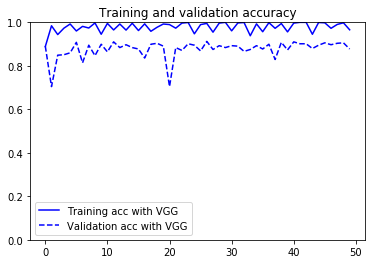

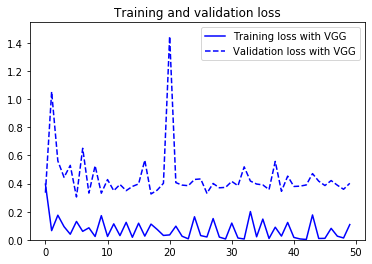

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

acc_perc=np.dot(acc,100)
val_acc_perc=np.dot(val_acc,100)
acc_2d=np.around(acc_perc, decimals=2)
val_acc_2d=np.around(val_acc_perc, decimals=2)
print("% training accuracy = {}%".format(acc_2d[-1]))
print("% validation accuracy = {}%".format(val_acc_2d[-1]))

plt.figure()
plt.ylim(0, 1)

plt.plot(epochs, acc, 'b', label='Training acc with VGG')
plt.plot(epochs, val_acc, 'b--', label='Validation acc with VGG')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
plt.ylim(0, max(val_loss)+0.1)
 
plt.plot(epochs, loss, 'b', label='Training loss with VGG')
plt.plot(epochs, val_loss, 'b--', label='Validation loss with VGG')
plt.title('Training and validation loss')
plt.legend()

 
plt.show()

### **Test accuracy**

Also, let us visually see the errors that we got.



In [16]:
from prettytable import PrettyTable

# Get the filenames from the generator
fnames = test_generator.filenames
 
# Get the ground truth from generator
ground_truth = test_generator.classes
 
# Get the label to class mapping from the generator
label2index = test_generator.class_indices
 
# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())

print('Model1')
# Get the predictions from the model using the generator
predictions = model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)
 
errors = np.where(predicted_classes != ground_truth)[0]
test_acc=100-(len(errors)/test_generator.samples*100)
test_acc_2d=np.around(test_acc, decimals=2)
print("No of errors = {}/{}".format(len(errors),test_generator.samples))
print("% test accuracy = {}%".format(test_acc_2d))

t = PrettyTable(['model', 'Accuracy'])
t.add_row(['FineTunned VGG', test_acc_2d])

print(t)

Model1
16/15 [==============================] - 1s 66ms/step
No of errors = 18/158
% test accuracy = 88.61%
+----------------+----------+
|     model      | Accuracy |
+----------------+----------+
| FineTunned VGG |  88.61   |
+----------------+----------+


## **Metrics**

In [17]:
print('Model')
print('Accuracy: '+str(accuracy_score(ground_truth, predicted_classes)))
print(classification_report(ground_truth, predicted_classes))
print(confusion_matrix(ground_truth, predicted_classes))

Model
Accuracy: 0.8860759493670886
              precision    recall  f1-score   support

           0       0.94      0.73      0.82        22
           1       0.79      0.96      0.86        23
           2       0.82      0.60      0.69        15
           3       0.88      0.94      0.91        16
           4       0.88      0.93      0.90        15
           5       0.93      0.93      0.93        14
           6       0.93      0.93      0.93        14
           7       0.82      0.93      0.87        15
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00        19

    accuracy                           0.89       158
   macro avg       0.90      0.89      0.89       158
weighted avg       0.89      0.89      0.88       158

[[16  3  0  1  0  1  0  1  0  0]
 [ 0 22  0  0  1  0  0  0  0  0]
 [ 1  2  9  1  1  0  0  1  0  0]
 [ 0  1  0 15  0  0  0  0  0  0]
 [ 0  0  1  0 14  0  0  0  0  0]
 [ 0  0  0  0  0 13  1  0  0  0]
 [ 0  0 

# **2. Loading the models already trained**

### Characteristics and names of the models

In [0]:
model_names=['4', '8', '12']
number_models=len(model_names)
#id of the files in Google Drive
ids= ['1b9eAEtxT7IcAdXzd-G1-I-RBQ66Ua3Yz', '17prVJs9Y_FgbzmbkHXbuFl50f75NtofW', '1Mi0RXmR9IGfVwkDWLlZC2wRCdpmhA76_']

### Authentize as a Drive User

In [20]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

for i, modelit in enumerate(model_names,1):
  print(i)
  file_obj = drive.CreateFile({'id': ids[i-1]})
  file_obj.GetContentFile(modelit+'.h5')

1
2
3


## **Results**

### Load the models and metrics(iterating)

Metrics:
  - accuracy
  - precision, recall, fscore
  - confussion matrix
  - log loss
  

In [21]:
errors50 = np.empty(int(number_models), dtype=object)
accuracy50 = np.empty(int(number_models), dtype=object)
report50 = np.empty(int(number_models), dtype=object)
cm50 = np.empty(int(number_models), dtype=object)
logloss50 = np.empty(int(number_models), dtype=object)
precision50 = np.empty(int(number_models), dtype=object)
recall50 = np.empty(int(number_models), dtype=object)
f150 = np.empty(int(number_models), dtype=object)

for i, name in enumerate(model_names, 1):
  print('Model: '+name+' (index '+str(i)+')')
  model50 = load_model(name+'.h5')
#  model.summary()

  test_dir = '/content/Ear-FineTunning/Dataset/'+name+'/test'
  print('Test directory: '+test_dir)
  test_datagen = ImageDataGenerator(rescale=1./255)
  test_batchsize = 10
  test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(image_size, image_size),
        batch_size=test_batchsize,
        class_mode='categorical',
        shuffle=False)

  fnames = test_generator.filenames
  ground_truth = test_generator.classes
  print('Ground truth: '+str(ground_truth))

  predictions = model50.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size,verbose=1)
  predicted_classes = np.argmax(predictions,axis=1)
  print('Predictions: '+str(predicted_classes))

  errors_ind=np.where(predicted_classes != ground_truth)[0]
  print(len(errors_ind))
  errors50[i-1]=len(errors_ind)
  print(errors50[i-1])
  print("No of errors = {}/{}".format(errors50[i-1],test_generator.samples))

  accuracy50[i-1]=accuracy_score(ground_truth, predicted_classes)
  print('Accuracy: '+str(accuracy50[i-1]))
  report50[i-1]=classification_report(ground_truth, predicted_classes)
  #print(report[i-1])
  cm50[i-1]=confusion_matrix(ground_truth, predicted_classes)
  print('Confusion Matrix: '+str(cm50[i-1]))
  logloss50[i-1]=log_loss(ground_truth,predictions)
  print('Cross-entropy loss: '+str(logloss50[i-1]))
  f150[i-1]=f1_score(ground_truth, predicted_classes, average='micro')
  print('F score: '+str(f150[i-1]))


Model: 4 (index 1)
Test directory: /content/Ear-FineTunning/Dataset/4/test
Found 76 images belonging to 4 classes.
Ground truth: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3]
8/7 [===============================] - 2s 219ms/step
Predictions: [0 0 0 3 0 1 1 0 3 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 1 2 1 2 0 3 2 2 3 2 3 2 3 2 3 3 3 3 3 3 3 3 3 1 1 3 3 3
 1 3]
16
16
No of errors = 16/76
Accuracy: 0.7894736842105263
Confusion Matrix: [[17  3  0  2]
 [ 0 23  0  0]
 [ 2  2  7  4]
 [ 0  3  0 13]]
Cross-entropy loss: 0.5271014884385391
F score: 0.7894736842105263
Model: 8 (index 2)
Test directory: /content/Ear-FineTunning/Dataset/8/test
Found 134 images belonging to 8 classes.
Ground truth: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 4 4 4

### Accuracies table

In [22]:
from prettytable import PrettyTable

t = PrettyTable(['model', 'Accuracy', 'Loss', 'F1 score'])

for i, name in enumerate(model_names, 1):
  t.add_row(['model '+str(name), accuracy50[i-1], logloss50[i-1], f150[i-1]])

print(t)

+----------+--------------------+---------------------+--------------------+
|  model   |      Accuracy      |         Loss        |      F1 score      |
+----------+--------------------+---------------------+--------------------+
| model 4  | 0.7894736842105263 |  0.5271014884385391 | 0.7894736842105263 |
| model 8  | 0.8507462686567164 | 0.49969913453795883 | 0.8507462686567164 |
| model 12 | 0.7551020408163265 |  0.6354543214039615 | 0.7551020408163265 |
+----------+--------------------+---------------------+--------------------+


### Graphs

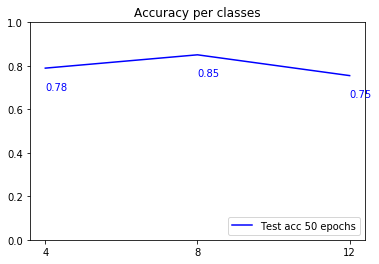

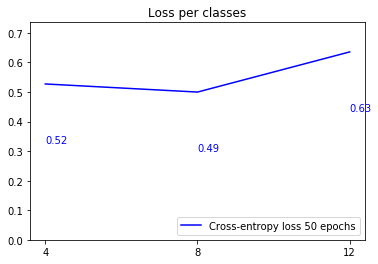

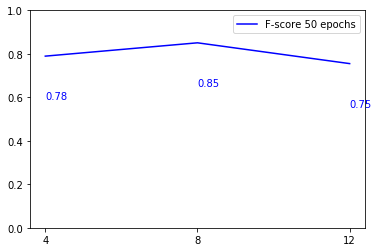

In [23]:
plt.plot(model_names, accuracy50, 'b', label='Test acc 50 epochs')

ax = plt.gca()
for i,j in zip(model_names, accuracy50):
  ax.annotate(str(float(str(j)[:4])),xy=(i,j-0.1),color='b')

plt.title('Accuracy per classes')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.show()

plt.plot(model_names, logloss50, 'b', label='Cross-entropy loss 50 epochs')
ax = plt.gca()
for i,j in zip(model_names, logloss50):
  ax.annotate(str(float(str(j)[:4])),xy=(i,j-0.2),color='b')
plt.title('Loss per classes')
plt.ylim(0, max(logloss50)+0.1)
plt.legend(loc='lower right')
plt.show()

plt.plot(model_names, f150, 'b', label='F-score 50 epochs')
ax = plt.gca()
for i,j in zip(model_names, f150):
  ax.annotate(str(float(str(j)[:4])),xy=(i,j-0.2),color='b')
plt.legend(loc='lower right')
plt.ylim(0, 1)
plt.legend()
plt.show()

# **3. Try it with your own photos**

Upload your own database and train it (section 1).

## **Setup the test data generator**

In [24]:
#put your own directory
test_dir = '/content/Ear-FineTunning/ourEars/test'

test_batchsize = 10
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(image_size, image_size),
        batch_size=test_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 147 images belonging to 10 classes.


## **Upload the model**

In [0]:
model_name='8'

## Authenticate yourself

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
#copy the previous id
file_obj = drive.CreateFile({'id': '146OBZVSLkYWAN-5Yk8CYMWWnNSchCzd9'})
file_obj.GetContentFile(model_name+'.h5')

## Define the model

Has to have the same structure as the trained one, and copy it's weights.

In [0]:
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
model = models.Sequential()
model.add(vgg_conv)
model.add(layers.Conv2D(filters=128, kernel_size=2, activation='sigmoid', use_bias=False))
model.add(layers.MaxPooling2D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(num_class, activation='softmax'))

model.load_weights(model_name+'.h5')





58892288/58889256 [==============================] - 2s 0us/step







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## **Test accuracy**

In [0]:
fnames = test_generator.filenames
ground_truth = test_generator.classes
label2index = test_generator.class_indices
idx2label = dict((v,k) for k,v in label2index.items())
predictions = model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size,verbose=1)
predicted_classes = np.argmax(predictions,axis=1) 
errors = np.where(predicted_classes != ground_truth)[0]
test_acc=100-(len(errors)/test_generator.samples*100)
test_acc_2d=np.around(test_acc, decimals=2)
print("No of errors = {}/{}".format(len(errors),test_generator.samples))
print("% test accuracy = {}%".format(test_acc_2d))

cm=confusion_matrix(ground_truth, predicted_classes)
print('Confusion Matrix: \n'+str(cm))

15/14 [==============================] - 5s 322ms/step
No of errors = 24/147
% test accuracy = 83.67%
Confusion Matrix: 
[[19  2  0  1  0  0  0  0  0  0]
 [ 0 23  0  0  0  0  0  0  0  0]
 [ 2  1 11  0  1  0  0  0  0  0]
 [ 1  3  0 12  0  0  0  0  0  0]
 [ 4  0  0  0  8  1  0  2  0  0]
 [ 1  0  0  0  0 13  0  0  0  0]
 [ 3  0  0  0  0  0 11  0  0  0]
 [ 1  0  1  0  0  0  0 13  0  0]
 [ 0  0  0  0  0  0  0  0  5  0]
 [ 0  0  0  0  0  0  0  0  0  8]]


### **Try with your photos**

Upload some photo on Google Drive and copy it's path

lluis


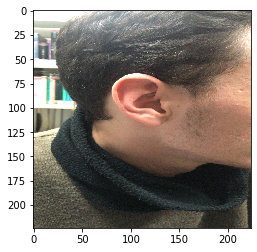

In [0]:
path="/content/Ear-FineTunning/exemple/WhatsApp Image 2019-12-16 at 17.52.39.jpeg"

img = load_img(path, target_size=(image_size, image_size))
plt.imshow(img)
img = np.expand_dims(img, axis=0)
result=model.predict_classes(img)
pred_label = idx2label[result.item(0)]

print(pred_label)

001.ALI_HD


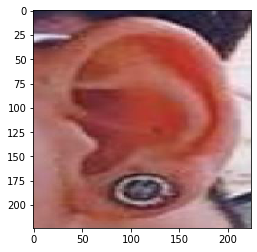

In [0]:
path="/content/Ear-FineTunning/exemple/001 (86).jpg"

img = load_img(path, target_size=(image_size, image_size))
plt.imshow(img)
img = np.expand_dims(img, axis=0)
result=model.predict_classes(img)
pred_label = idx2label[result.item(0)]

print(pred_label)

lluis


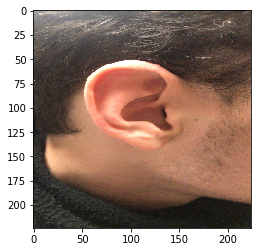

In [0]:
path="/content/Ear-FineTunning/exemple/WhatsApp Image 2019-12-16 at 17.52.40.jpeg"

img = load_img(path, target_size=(image_size, image_size))
plt.imshow(img)
img = np.expand_dims(img, axis=0)
result=model.predict_classes(img)
pred_label = idx2label[result.item(0)]

print(pred_label)

006.Chau_GK


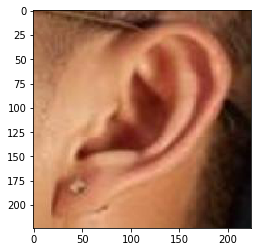

In [0]:
path="/content/Ear-FineTunning/exemple/006 (88).jpg"

img = load_img(path, target_size=(image_size, image_size))
plt.imshow(img)
img = np.expand_dims(img, axis=0)
result=model.predict_classes(img)
pred_label = idx2label[result.item(0)]

print(pred_label)